In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc
import shap

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [3]:
model_number = 11

train_times = pd.read_csv(Directory+f'/test_train_times/times_train_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(Directory+f'/test_train_times/times_test_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times)
print(test_times)

[49  5 33 54 26  8 17 46 20 60 57 13 31  7 11  3 62  9 56  1 44 32 52 35
 22 58 24 47 55 42 23  2 14 27 43 10 21 34 59 45 51  4 41 29 25 18 53 19
 28]
[12 36 37 50 40 16 48 38  6 39 15 61 30]


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)
ins = [input_train, input_test]
outs = [output_train, output_test]

for input in ins:
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= input[:,i].mean()
        input[:,i] /= input[:,i].std()
    input = input.reshape(-1,(len(variables)-1)*nz)
    input = input.to(device)

mean_out = output_train.mean()
std_out = output_train.std()

for output in outs:
    output -= output.mean()
    output /= output.std()
    output = output.to(device)

In [5]:
mean_out

tensor(0.0027)

## Define the model

In [6]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.BatchNorm1d(input_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [41]:
class pca_DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=256, hidden_size2=512, hidden_size3=256):
        super(pca_DNN, self).__init__()
        self.regression = nn.Sequential(nn.BatchNorm1d(input_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [7]:
learning_rate = 0.001
batch_size = 16
nb_epochs = 20
train_losses=[]
test_losses=[]
n_batches = input_train.shape[0]//batch_size

## Use previous models

!!! This section only works with coarse_factors = [32] !!!

In [8]:
model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/model_bash_0.pt', map_location=torch.device('cpu')))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): BatchNorm1d(2256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2256, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.4, inplace=False)
    (13): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [9]:
tot_losses=0

model_load.eval()
# prediction
output_pred = model_load(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='mean')

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.097668


In [10]:
output_test.shape

torch.Size([3328, 376])

Plot the coarse grained heat flux (both predicted and real) from the reconstructed output and objective of the DNN.

t = 12


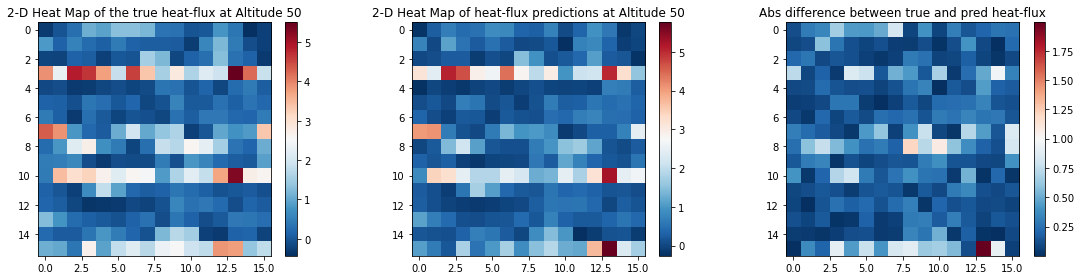

5.7592764 -0.2642122 0.7929969


In [11]:
t = 0
z=50
L=32
largeur = int(512/L)
pred_ds = output_pred[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()
true_ds = output_test[t*largeur**2:(t+1)*largeur**2,:].cpu().detach().numpy()

#print(pred_ds)
print('t =',test_times[t])
utils.plot_output(pred_ds,true_ds,L,z,color='RdBu_r')

print(pred_ds[:,z].max(),pred_ds[:,z].min(),true_ds[:,z].mean())

Plot the coarse grained heat flux from Adrien's written nc files.

temperature mean,min,max: 4.204926337680881e-14 -0.03165074157710627 0.061557266235395244
wtheta mean,min,max : 0.007573274349059544 8.988731202149423e-06 0.03667380056919889


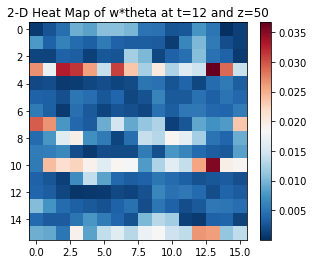

In [12]:
path_data = Directory+f'/L_{L}/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()[:,-len_out+z].reshape(16,16) 
theta_ds = nc_init['sample'][:].filled()[:,3*len_out+z].reshape(16,16)
print('temperature mean,min,max:', theta_ds.mean(),theta_ds.min(),theta_ds.max())
print('wtheta mean,min,max :',test_ds.mean(),test_ds.min(),test_ds.max())
im = plt.imshow(test_ds , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.title(f"2-D Heat Map of w*theta at t={test_times[t]} and z={z}")
plt.show()

## Define baseline model

Baseline model : $\overline{w*\theta} \simeq \overline{w}*\overline{\theta}$

Comparison of objective heat flux, baseline heat flux and element wise difference of them.

In [13]:
L=32

path_data = Directory+f'/L_{L}/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'
nc_init = nc.Dataset(path_data)
time_ds = nc_init['sample'][:].filled()
time_ds[:,len_in:][:,z].shape

(256,)

12
Mean,min,max temperature fluctuation : 4.204926337680881e-14 -0.03165074157710627 0.061557266235395244
Mean,min,max true heat flux : tensor(0.7922, dtype=torch.float64) tensor(-0.4289, dtype=torch.float64) tensor(5.4902, dtype=torch.float64)
Mean,min,max baseline heat flux : tensor(0.0561, dtype=torch.float64) tensor(-0.7563, dtype=torch.float64) tensor(3.6228, dtype=torch.float64)


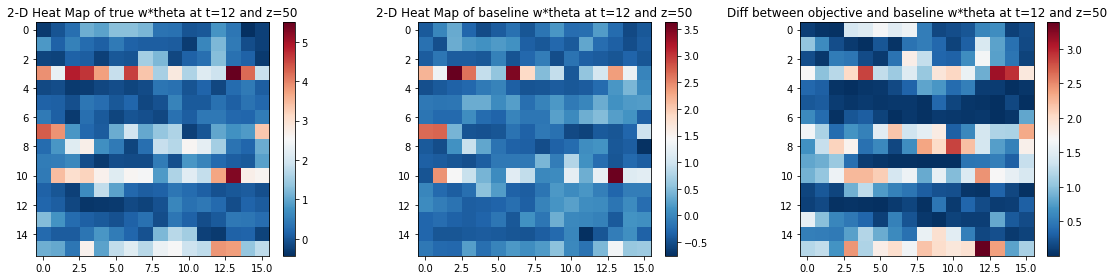

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t=0
lz=376
L=32
#z=100     # equivalent to z=18 : first alt is 18
print(test_times[t])
path_data = Directory+f'/L_{L}/input_ds_for_simple_nn_T{test_times[t]}_L_{L}.nc'  #'data/L_32_new/input_ds_for_simple_nn_T10_L_32.nc'
nc_init = nc.Dataset(path_data)
true_heat_flux = nc_init[f'sample'][:].filled()[:,-len_out:][:,z].reshape(16,16)        # -len_out because : last len_out values are wtheta, z is wtheta at alt z
true_heat_flux -= mean_out.numpy()
true_heat_flux /= std_out

w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:3*len_out][:,z].reshape(16,16)        # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:4*len_out][:,z].reshape(16,16)    # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta
baseline_heat_flux = w_arr*theta_arr
baseline_heat_flux -= mean_out.numpy()
baseline_heat_flux /= std_out

print('Mean,min,max temperature fluctuation :',theta_arr.mean(),theta_arr.min(),theta_arr.max())
print('Mean,min,max true heat flux :',true_heat_flux.mean(),true_heat_flux.min(),true_heat_flux.max())
print('Mean,min,max baseline heat flux :',baseline_heat_flux.mean(),baseline_heat_flux.min(),baseline_heat_flux.max())

fig,axes = plt.subplots(1,3,figsize=(16,4))

im0 = axes[0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im1 = axes[1].imshow(baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"2-D Heat Map of baseline w*theta at t={test_times[t]} and z={z}")

im2 = axes[2].imshow(np.abs(true_heat_flux - baseline_heat_flux) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[2].set_title(f"Diff between objective and baseline w*theta at t={test_times[t]} and z={z}")

fig.tight_layout()
plt.show()

Problem : with $\theta$ and not $\theta'$, the baseline seems to be way closer to the objective than NN.

Normal vu que on utilise $\theta$ et non pas $\theta'$ donc on a $\theta \simeq 293K$ en permanence. On peut donc le considérer comme constant et $\overline{\theta} = \theta$, d'où $$\overline{w*\theta} = \overline{w*\overline{\theta}} =\overline{w}*\overline{\theta}$$

-> il faut considérer $\theta'$

Si on considère $\theta'$, on remarque que le baseline model approxime bien le flux de chaleur sur les zones où il n'y a quasi pas de flux (grandes zones) et mal sur les zones de fort flux (petites zones qui sont donc moyennées avec ce qui les entoure).

-> On peut faire mieux.

## Compare model and baseline

In [18]:
w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:3*len_out].reshape(16,16,376)       # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:4*len_out].reshape(16,16,376)     # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta

baseline_arr = w_arr*theta_arr
baseline_arr = (baseline_arr - mean_out.numpy())/std_out.numpy()
pred_arr = pred_ds.reshape(16,16,376)
true_arr = true_ds.reshape(16,16,376)

print(true_arr.min(),true_arr.max(),true_arr.mean(),true_arr.std())
print(pred_arr.min(),pred_arr.max(),pred_arr.mean(),pred_arr.std())
print(baseline_arr.min(),baseline_arr.max(),baseline_arr.mean(),baseline_arr.std())

-6.0518875 7.557317 0.002563857 1.0383118
-5.698167 9.12297 0.031084929 0.91538304
-3.9772054921147615 6.269197935102143 -0.25487757585119375 0.6265150201735377


In [20]:
baseline_loss = 0
pred_loss = 0
pred_losses = []
baseline_losses = []
for i in range(16):
    for j in range(16):
        for a in range(376):
            baseline_loss += (true_arr[i,j,a] - baseline_arr[i,j,a])**2
            pred_loss += (true_arr[i,j,a] - pred_arr[i,j,a])**2
            baseline_losses.append((true_arr[i,j,a] - baseline_arr[i,j,a])**2)
            pred_losses.append((true_arr[i,j,a] - pred_arr[i,j,a])**2)
            
print('baseline loss :',baseline_loss)
print('pred loss :', pred_loss)
print('baseline loss :',np.mean(baseline_losses), ', baseline loss max :',np.max(baseline_losses))
print('pred loss mean :',np.mean(pred_losses), ', pred loss max :',np.max(pred_losses))

baseline loss : 44652.61628741734
pred loss : 9029.39118551162
baseline loss : 0.46389436801256967 , baseline loss max : 18.767885894055706
pred loss mean : 0.09380600882553486 , pred loss max : 11.133964409706095


Below is a comparison of the losses with L=32. Got to beware that losses can vary a bit depending on the test_times.
- Basline loss on 1 test time (256 samples) is $1.604546475286402$, with test_times 10 ds
- Model 8 loss on 1 test time (256 samples) is $0.22655215267993511$, with test_times 8 ds
- Model 9 loss on 1 test time (256 samples) is $0.61567400705534776$, with test_times 9 ds
- Model 10 loss on 1 test time (256 samples) is $0.5664234623353515$, with test_times 10 ds

Model 8 is simple dnn with 3 hidden layers of size (1024, 512, 256) and a learning rate of $10^{-6}$. Trained for 400 epochs (no overfitting yet).

Model 9 is simple dnn with 3 hidden layers of size (1024, 512, 256) and an exp decaying learning rate starting at $10^{-5}$ and with $\gamma = 0.99$ until the 500th epoch : $lr = 6.6*10^{-8}$. Trained for 1000 epochs. Either lr too small after 500 epochs or we've reach the best we can do before overfitting.


## Compare model and baseline with L = 16,32,64,128

In [42]:
# load model
batch_size = 32
model_number = 10
reduced_len = 30

model_load = pca_DNN(batch_size=batch_size,input_size=reduced_len,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/pca_0.pt', map_location=torch.device('cpu')))
model_load.eval()

pca = True


In [43]:
# true and baseline 
t = 0
z=100
coarse_factors = [128,64,32,16]
largeurs = [int(512/coarse_factors[i]) for i in range(len(coarse_factors))]

baseline_samples = []

for i in range(len(coarse_factors)) :
    path_data = f'data/L_{coarse_factors[i]}/input_ds_for_simple_nn_T{test_times[t]}_L_{coarse_factors[i]}.nc'  #'data/L_32_new/input_ds_for_simple_nn_T10_L_32.nc'
    nc_init = nc.Dataset(path_data)
    w_arr = nc_init[f'sample'][:].filled()[:,2*len_out:3*len_out].reshape(largeurs[i],largeurs[i],376)      # variables are [u,v,w,theta,s,tka,wtheta] so 2*len_out is w
    theta_arr = nc_init[f'sample'][:].filled()[:,3*len_out:4*len_out].reshape(largeurs[i],largeurs[i],376)    # variables are [u,v,w,theta,s,tka,wtheta] so 3*len_out is theta
    baseline_samples.append(w_arr*theta_arr)
    baseline_samples[-1] -= baseline_samples[-1].mean()
    baseline_samples[-1] /= baseline_samples[-1].std()

In [44]:
# init test ds and evaluate predictions
test_samples = []
input_tests = []
output_tests = []

for i in range(len(coarse_factors)) :
    path_data = f'data/L_{coarse_factors[i]}/input_ds_for_simple_nn_T{test_times[0]}_L_{coarse_factors[i]}.nc'
    nc_init = nc.Dataset(path_data)
    test_ds = nc_init['sample'][:].filled()
    for t in test_times:
        if t == test_times[0] :
            continue
        path_data = f'data/L_{coarse_factors[i]}/input_ds_for_simple_nn_T{t}_L_{coarse_factors[i]}.nc'
        nc_init = nc.Dataset(path_data)
        time_ds = nc_init['sample'][:].filled()
        test_ds = np.concatenate((test_ds, time_ds), axis=0)
    test_samples.append(test_ds)

for i in range(len(coarse_factors)):
    input, output = test_samples[i][:,:len_in], test_samples[i][:,len_in:]
    # test : convert numpy array to torch tensor
    input_tests.append(torch.from_numpy(input).float())
    output_tests.append(torch.from_numpy(output).float())

for input in input_tests:
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= input[:,i].mean()
        input[:,i] /= input[:,i].std()
    input = input.reshape(-1,(len(variables)-1)*nz)
    input = input.to(device)
for output in output_tests:
    output -= output.mean()
    output /= output.std()
    output = output.to(device)

if pca :
    pca_data = input_tests[0]
    for i in range(1,len(coarse_factors)) :
        pca_data = torch.concat((pca_data,input_tests[i]),axis=0)
    U,S,V = torch.pca_lowrank(pca_data, q=reduced_len)

    for i in range(len(input_tests)) :
        input_tests[i] = torch.mm(input_tests[i], V)

model_load.eval()
# prediction
output_preds = [model_load(input_tests[i]) for i in range(len(coarse_factors))]
# compute loss
losses = [F.mse_loss(output_preds[i], output_tests[i], reduction='sum') / (input_tests[i].shape[0]//batch_size) for i in range(len(coarse_factors))]

t = 0
pred_ds = [output_preds[i][t*largeurs[i]**2:(t+1)*largeurs[i]**2,:].cpu().detach().numpy() for i in range(len(coarse_factors))]
true_ds = [output_tests[i][t*largeurs[i]**2:(t+1)*largeurs[i]**2,:].cpu().detach().numpy() for i in range(len(coarse_factors))]

In [45]:
pred_ds[0].shape

(16, 376)

In [46]:
baseline_losses = []
pred_losses = []

for l in range(len(coarse_factors)):
    baseline_arr = baseline_samples[l]
    pred_arr = pred_ds[l].reshape(largeurs[l],largeurs[l],376)
    true_arr = true_ds[l].reshape(largeurs[l],largeurs[l],376)
    b_losses = []
    p_losses = []
    for i in range(largeurs[l]):
        for j in range(largeurs[l]):
            for a in range(376):
                b_losses.append((true_arr[i,j,a] - baseline_arr[i,j,a])**2)
                p_losses.append((true_arr[i,j,a] - pred_arr[i,j,a])**2)
    baseline_losses.append(np.mean(b_losses))
    pred_losses.append(np.mean(p_losses))

print('coarsening factors :',coarse_factors)
print('baseline loss :',baseline_losses)
print('pred loss :', pred_losses)
#print('scaled baseline loss :',[baseline_losses[i]*(16**2)/(largeurs[i]**2) for i in range(len(coarse_factors))])
#print('scaled pred loss :', [pred_losses[i]*(16**2)/(largeurs[i]**2) for i in range(len(coarse_factors))])

coarsening factors : [128, 64, 32, 16]
baseline loss : [1.3532746481111162, 0.8943162336949546, 0.36545866332028615, 0.1668805636424982]
pred loss : [0.7355675751299142, 0.8668244808310306, 0.9017611760952063, 0.9375040947603692]


Contrairement à ce qu'on pourrait penser : moins bon résultats pour les petits coarse factors alors qu'on a beaucoup plus d'échantillons.

In [22]:
d = {'baseline': [1.95459, 2.10890, 1.60455, 1.220004],
'model': [0.10363, 0.24179, 0.56642, 2.24540]
}
print ("{:<20} {:<10} {:<10} {:<10} {:<10}".format('normalized loss','L=128','L=64','L=32','L=16'))
for k, v in d.items():
    L128, L64, L32, L16 = v
    print ("{:<20}{:<10} {:<10} {:<10} {:<10}".format(k, L128, L64, L32, L16))

normalized loss      L=128      L=64       L=32       L=16      
baseline            1.95459    2.1089     1.60455    1.220004  
model               0.10363    0.24179    0.56642    2.2454    


## Plots

In [55]:
# L=[128,64,32,16]
# largeurs=[int(512/L[i]) for i in range(len(L))]
l=3     #adjust the coarse factor here
z=50
t=0

baseline_arr = baseline_samples[l]
pred_arr = pred_ds[l].reshape(largeurs[l],largeurs[l],376)
true_arr = true_ds[l].reshape(largeurs[l],largeurs[l],376)

12


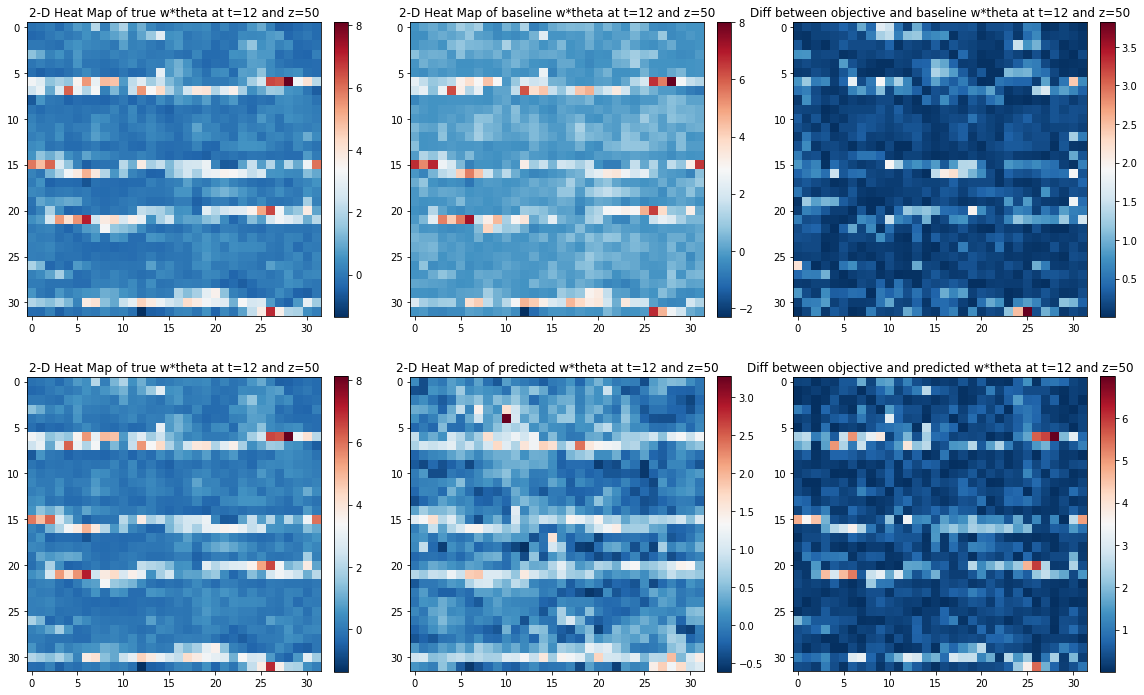

In [56]:
print(test_times[t])
true_heat_flux = true_arr[:,:,z]      
pred_heat_flux = pred_arr[:,:,z]
baseline_heat_flux = baseline_arr[:,:,z]

fig,axes = plt.subplots(2,3,figsize=(16,10))

im0 = axes[0,0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0,0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im1 = axes[0,1].imshow(baseline_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[0,1], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,1].set_title(f"2-D Heat Map of baseline w*theta at t={test_times[t]} and z={z}")

im2 = axes[0,2].imshow(np.abs(true_heat_flux - baseline_heat_flux) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im2, ax=axes[0,2], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,2].set_title(f"Diff between objective and baseline w*theta at t={test_times[t]} and z={z}")

im3 = axes[1,0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im3, ax=axes[1,0], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im4 = axes[1,1].imshow(pred_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im4, ax=axes[1,1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,1].set_title(f"2-D Heat Map of predicted w*theta at t={test_times[t]} and z={z}")

im5 = axes[1,2].imshow(np.abs(true_heat_flux - pred_heat_flux) , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im5, ax=axes[1,2], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,2].set_title(f"Diff between objective and predicted w*theta at t={test_times[t]} and z={z}")

fig.tight_layout()
plt.show()

## Compare whole BL and one_alt models

In [58]:
learning_rate = 0.001
batch_size = 16
nb_epochs = 20
train_losses=[]
test_losses=[]

model_one_alt = DNN(batch_size=batch_size,input_size=len_in+1,output_size=1)
model_one_alt.load_state_dict(torch.load(f'explo/models/simple_dnn_one_alt_3'))     #only trained for L=32

RuntimeError: Error(s) in loading state_dict for DNN:
	Missing key(s) in state_dict: "regression.0.running_mean", "regression.0.running_var", "regression.1.weight", "regression.1.bias", "regression.3.running_mean", "regression.3.running_var", "regression.5.weight", "regression.5.bias", "regression.7.weight", "regression.7.bias", "regression.7.running_mean", "regression.7.running_var", "regression.11.weight", "regression.11.bias", "regression.11.running_mean", "regression.11.running_var", "regression.13.weight", "regression.13.bias". 
	Unexpected key(s) in state_dict: "regression.6.weight", "regression.6.bias". 
	size mismatch for regression.0.weight: copying a param with shape torch.Size([1024, 2257]) from checkpoint, the shape in current model is torch.Size([2257]).
	size mismatch for regression.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2257]).
	size mismatch for regression.3.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for regression.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for regression.9.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for regression.9.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([256]).

In [ ]:
l=2
pred_whole = 0

pred_arr = pred_ds[l].reshape(largeurs[l],largeurs[l],376)
true_arr = true_ds[l].reshape(largeurs[l],largeurs[l],376)
for i in range(largeurs[l]):
    for j in range(largeurs[l]):
        for a in range(376):
            pred_whole += (true_arr[i,j,a] - pred_arr[i,j,a])**2

In [ ]:
input_one_alt_init = input_tests[l][t*largeurs[l]**2:(t+1)*largeurs[l]**2,:]

pred_losses_one_alt = 0

for z in range(376):
    input_one_alt = torch.cat((input_one_alt_init, torch.ones((input_one_alt_init.shape[0],1))*z), 1)
    output_preds_one_alt = model_one_alt(input_one_alt)
    preds_one_alt = output_preds_one_alt.cpu().detach().numpy().reshape(largeurs[l],largeurs[l])
    for i in range(largeurs[l]):
        for j in range(largeurs[l]):
            pred_losses_one_alt += (true_arr[i,j,z] - preds_one_alt[i,j])**2

In [ ]:
print('whole BL loss :', pred_whole)
print('one_alt loss :', pred_losses_one_alt)

whole BL loss : 0.5664234623353515
one_alt loss : 1415129.6940352258


Model one_alt est bien moins bon, mais entraîné un peu à l'arrache.

### Plot

(16, 16)


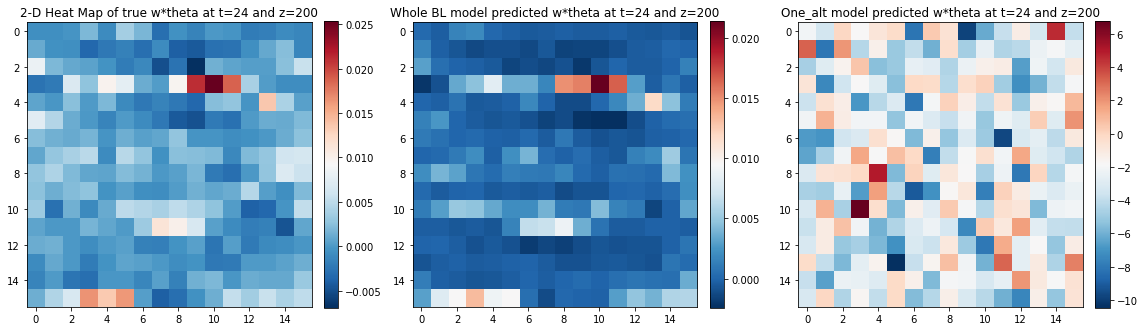

In [ ]:
z = 200
pred_arr = pred_ds[l].reshape(largeurs[l],largeurs[l],376)
true_arr = true_ds[l].reshape(largeurs[l],largeurs[l],376)
true_heat_flux = true_arr[:,:,z]      
pred_heat_flux = pred_arr[:,:,z]

input_one_alt_init = input_tests[l][t*largeurs[l]**2:(t+1)*largeurs[l]**2,:]
input_one_alt = torch.cat((input_one_alt_init, torch.ones((input_one_alt_init.shape[0],1))*z), 1)
output_preds_one_alt = model_one_alt(input_one_alt).reshape(largeurs[l],largeurs[l]).detach().numpy()
print(output_preds_one_alt.shape)

fig,axes = plt.subplots(1,3,figsize=(16,5))

im0 = axes[0].imshow(true_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f"2-D Heat Map of true w*theta at t={test_times[t]} and z={z}")

im1 = axes[1].imshow(pred_heat_flux , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1].set_title(f"Whole BL model predicted w*theta at t={test_times[t]} and z={z}")

im2 = axes[2].imshow(output_preds_one_alt , cmap = 'RdBu_r' , interpolation = 'nearest' )
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[2].set_title(f"One_alt model predicted w*theta at t={test_times[t]} and z={z}")

fig.tight_layout()
plt.show()

## SHAP values

In [25]:
# load model
batch_size = 16
model_number = 10

model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/model_bash_1.pt', map_location=torch.device('cpu')))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): BatchNorm1d(2256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2256, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.4, inplace=False)
    (13): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [35]:
input_test[:,:200].shape

torch.Size([3328, 200])

In [38]:
explainer = shap.Explainer(model_load)
shap_values = explainer.shap_values(input_test)

TypeError: 'NoneType' object is not callable